In [1]:
#-----------------------------------------------------------------------------------------------------------------
# Simulation experiment
#
# Network:
# A--> B --> gene set D
# A --> gene set C
#
# Algorithm
# Let gene A and B be TF's:
# if gene A expression > threshold_A:
#     genes in set C are upregulated
#     gene B is upregulated
# if gene B expression > threshold_B:
#    genes in set D are upregulated
#
# Apply this algorithm for each sample in the compendium (essentially adding a signal to the existing gene expression data in the compendium)
# 
# Hyperparmeters should include: 
# 1. Gene A, B
# 2. Size of gene sets C and D (D << C)
# 3. Thresholds
# 4. Percentage to 1.0 (effect size)
# 5. Gene set C and D mutually exclusive?
# 6. Log file with hyperparameter selections
#-----------------------------------------------------------------------------------------------------------------

import os
import pandas as pd
import numpy as np
import random

from functions import generate_input, vae, def_offset, interpolate, plot

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Hyperparameters

# Transcription factors
# If empty, genes will be randomly assigned
geneA = ''
geneB = ''

# Size of the gene sets that will be regulated by gene A and B
# Note gene set C will automatically include gene B based on network architecture
geneSetC_size = 100 
geneSetD_size = 100

# Percentage of mixture between the gene sets C and D (i.e. percentabe of genes that overlap)
mixture = 0

# Threshold for activation of gene A and gene B
thresholdA = 0.5
thresholdB = 0.7

# Amount that genes in gene sets C and D are upregulated
effect_sizeA = 0.3
effect_sizeB = 0.3

# Name of analysis
analysis_name = 'sim_1_8'

In [3]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")

In [4]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# Randomly select gene A and gene B if not specified
# Note: 'replace=False' indicates sampling WITHOUT replacement
if not geneA and not geneB:
    gene_ids = list(data.columns)
    [geneA, geneB] = np.random.choice(gene_ids, size=2, replace=False)

print(geneA)
print(geneB)

PA0996
PA4530


In [6]:
# Randomly select genes for gene set C
# remove() doesn't return a value it will remove the element from the list object
gene_ids.remove(geneA)
gene_ids.remove(geneB)
print(len(gene_ids))

# Random sample of genes for set C
geneSetC = random.sample(gene_ids, geneSetC_size)

# Remove selected genes
gene_ids = [c for c in gene_ids if c not in geneSetC]

print(len(geneSetC))

5547
100


In [7]:
# Randomly select genes for gene set D, accounting for percent mixture with gene set C
#geneSetD = random.sample(gene_ids, geneSetD_size)

# Sample a percentage of genes from gene set C
num_shared = round(mixture*geneSetC_size)
num_remaining = geneSetD_size - num_shared

# Add sampled percentage of genes to gene set D
# Fill in remaining samples for gene set D
geneSetD = random.sample(geneSetC, num_shared)
geneSetD = geneSetD + random.sample(gene_ids, num_remaining)

print(len(geneSetD))

100


In [8]:
# Add geneB to gene set C
geneSetC.append(geneB)

In [9]:
# Loop through all samples
num_samples = data.shape[1]

for sample_id in data.index:
    row = data.loc[sample_id]
        
    if data.loc[sample_id,geneA] > thresholdA:
        # Scale genes by some fixed percentage
        for gene in geneSetC:
            data.loc[sample_id,gene] = data.loc[sample_id,gene]*(1+effect_sizeA)            
    if data.loc[sample_id,geneB] > thresholdB:
        for gene in geneSetD:
            data.loc[sample_id,gene] = data.loc[sample_id,gene]*(1+effect_sizeB)
            
# if any exceed 1 then set to 1 since gene expression is normalized
data[data>=1.0] = 1.0

In [10]:
# Dataframe with only gene A
geneA_only = pd.DataFrame(data[geneA], index=data.index, columns=[geneA])

# Drop gene A
data_holdout = data.drop(columns=[geneA])

In [11]:
# Create list of base directories
base_dirs = [os.path.join(os.path.dirname(os.getcwd()), 'data'),
             os.path.join(os.path.dirname(os.getcwd()), 'encoded'),
             os.path.join(os.path.dirname(os.getcwd()), 'models'),
             os.path.join(os.path.dirname(os.getcwd()), 'output'),
             os.path.join(os.path.dirname(os.getcwd()), 'stats'),
             os.path.join(os.path.dirname(os.getcwd()), 'viz')    
]

# Check if directory exist otherwise create
for each_dir in base_dirs:
    analysis_dir = os.path.join(each_dir, analysis_name)
    if os.path.exists(analysis_dir):
        print('directory already exists: {}'.format(analysis_dir))
    else:
        os.mkdir(analysis_dir)
        print('creating new directory: {}'.format(analysis_dir))

creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/data/sim_1_8
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/encoded/sim_1_8
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/models/sim_1_8
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/output/sim_1_8
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/stats/sim_1_8
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/viz/sim_1_8


In [12]:
# Output the new gene expression values for each sample
train_input_file = os.path.join(base_dirs[0], analysis_name, "train_model_input.txt.xz")
data_holdout.to_csv(train_input_file, sep='\t', compression='xz', float_format="%.5g")

# Output log file with params
log_file = os.path.join(os.path.dirname(os.getcwd()), 'metadata', analysis_name)

args_dict = {
    "gene A": geneA,
    "gene B": geneB,
    "size of gene set C": geneSetC_size,
    "genes in set C": geneSetC,
    "size of gene set D": geneSetD_size,
    "genes in set D": geneSetD,
    "percentage of shared genes between C and D": mixture,
    "threshold of A activation": thresholdA,
    "threshold of B activation": thresholdB,
    "effect size of genes in set C": effect_sizeA,
    "effect size of genes in set D": effect_sizeB
}

with open(log_file, 'w') as f:
    for key, value in args_dict.items():
        f.write('%s: %s\n' % (key, value))
        
# Output geneA only file
geneA_file = os.path.join(base_dirs[0], analysis_name, geneA + ".txt")
geneA_only.to_csv(geneA_file, sep='\t', float_format="%.5g")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/vae.py:259: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


Train on 1072 samples, validate on 119 samples
Epoch 1/200
1072/1072 [==============================] - 1s 1ms/step - loss: 3750.7108 - val_loss: 3612.5797
Epoch 2/200
1072/1072 [==============================] - 1s 842us/step - loss: 3587.9292 - val_loss: 3546.3415
Epoch 3/200
1072/1072 [==============================] - 1s 782us/step - loss: 3522.6845 - val_loss: 3636.8375
Epoch 4/200
1072/1072 [==============================] - 1s 862us/step - loss: 3502.7482 - val_loss: 3544.9945
Epoch 5/200
1072/1072 [==============================] - 1s 852us/step - loss: 3486.0850 - val_loss: 3526.4851
Epoch 6/200
1072/1072 [==============================] - 1s 854us/step - loss: 3481.1011 - val_loss: 3508.2803
Epoch 7/200
1072/1072 [==============================] - 1s 835us/step - loss: 3474.3422 - val_loss: 3494.0714
Epoch 8/200
1072/1072 [==============================] - 1s 854us/step - loss: 3470.1826 - val_loss: 3490.5473
Epoch 9/200
1072/1072 [==============================] - 1s 841us/s

Epoch 74/200
1072/1072 [==============================] - 1s 848us/step - loss: 3384.9877 - val_loss: 3405.8996
Epoch 75/200
1072/1072 [==============================] - 1s 835us/step - loss: 3382.2986 - val_loss: 3406.8413
Epoch 76/200
1072/1072 [==============================] - 1s 783us/step - loss: 3382.8561 - val_loss: 3403.3537
Epoch 77/200
1072/1072 [==============================] - 1s 827us/step - loss: 3380.9273 - val_loss: 3404.6236
Epoch 78/200
1072/1072 [==============================] - 1s 844us/step - loss: 3381.1422 - val_loss: 3402.1745
Epoch 79/200
1072/1072 [==============================] - 1s 830us/step - loss: 3379.9737 - val_loss: 3404.6280
Epoch 80/200
1072/1072 [==============================] - 1s 825us/step - loss: 3380.1568 - val_loss: 3405.6057
Epoch 81/200
1072/1072 [==============================] - 1s 782us/step - loss: 3380.7429 - val_loss: 3402.5373
Epoch 82/200
1072/1072 [==============================] - 1s 786us/step - loss: 3378.7805 - val_loss: 34

1072/1072 [==============================] - 1s 811us/step - loss: 3354.8790 - val_loss: 3380.4492
Epoch 147/200
1072/1072 [==============================] - 1s 802us/step - loss: 3354.1514 - val_loss: 3376.8638
Epoch 148/200
1072/1072 [==============================] - 1s 779us/step - loss: 3354.7468 - val_loss: 3378.3306
Epoch 149/200
1072/1072 [==============================] - 1s 785us/step - loss: 3355.2812 - val_loss: 3382.6135
Epoch 150/200
1072/1072 [==============================] - 1s 826us/step - loss: 3354.0673 - val_loss: 3378.0513
Epoch 151/200
1072/1072 [==============================] - 1s 777us/step - loss: 3353.8149 - val_loss: 3375.0940
Epoch 152/200
1072/1072 [==============================] - 1s 813us/step - loss: 3351.6464 - val_loss: 3381.1546
Epoch 153/200
1072/1072 [==============================] - 1s 793us/step - loss: 3353.1744 - val_loss: 3379.0862
Epoch 154/200
1072/1072 [==============================] - 1s 832us/step - loss: 3351.9514 - val_loss: 3373.82

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of genes in low expression group is (60, 5548)
Number of gene in high expression group is (60, 5548)


/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/plot.py:46: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X_sorted = X.loc[sorted_id.index].dropna()


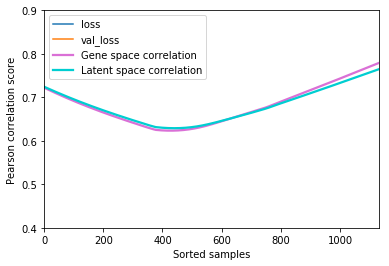

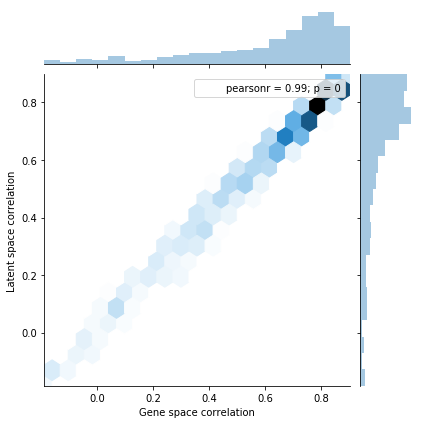

In [13]:
%time
# Run Tybalt
learning_rate = 0.001
batch_size = 100
epochs = 200
kappa = 0.01
intermediate_dim = 100
latent_dim = 10
epsilon_std = 1.0

base_dir = os.path.dirname(os.getcwd())
vae.tybalt_2layer_model(learning_rate, batch_size, epochs, kappa, intermediate_dim, latent_dim, epsilon_std, base_dir, analysis_name)


# Define offset vectors in gene space and latent space
data_dir = os.path.join(base_dirs[0], analysis_name)
target_gene = geneA
percent_low = 5
percent_high = 95

def_offset.gene_space_offset(data_dir, target_gene, percent_low, percent_high)

model_dir = os.path.join(base_dirs[2], analysis_name)
encoded_dir = os.path.join(base_dirs[1], analysis_name)

def_offset.latent_space_offset(data_dir, model_dir, encoded_dir, target_gene, percent_low, percent_high)


# Predict gene expression using offset in gene space and latent space
out_dir = os.path.join(base_dirs[3], analysis_name)

interpolate.interpolate_in_gene_space(data_dir, target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_latent_space(data_dir, model_dir, encoded_dir, target_gene, out_dir, percent_low, percent_high)


# Plot prediction per sample along gradient of PA1673 expression
viz_dir = os.path.join(base_dirs[5], analysis_name)
plot.plot_corr_gradient(out_dir, viz_dir)